<a href="https://colab.research.google.com/github/dqj5182/Weight_Initialization_Method_using_Monte_Carlo_Simulation/blob/main/Monte_Carlo_Initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

In [22]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [23]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                         transforms.RandomRotation(degrees=(-10, 10)),
                                         transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                         transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                        contrast=(1, 1.5),
                                                                                        saturation=(1, 1.5),
                                                                                        hue=(0, 0.5))]),
                                         transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                  inplace=False),
                                         transforms.Resize((75, 75)),
                                         transforms.Normalize((0.5,), (0.5,))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


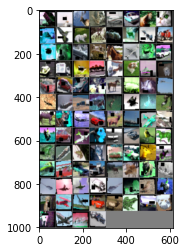

truck  ship  deer   cat plane   car horse   cat  deer  bird   dog horse   car  deer plane truck   dog   dog   car  frog horse plane  frog   car  ship truck  bird plane truck   dog  ship   dog   car   car  bird  deer horse plane   cat plane  deer  ship truck  deer  deer plane   cat  bird horse   cat plane   car  deer  ship plane plane horse   car plane  bird plane   car  bird horse  frog  ship  frog   cat  ship   car  deer horse  deer plane   car truck horse  deer   dog  ship plane plane plane truck plane  bird  bird horse   dog plane plane   car  deer  frog plane   cat   dog plane  ship   car


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [25]:
import torch.nn as nn
import torch.nn.functional as F


resnet50 = models.resnet50(pretrained=True)

n_inputs = resnet50.fc.in_features

last_layer = nn.Sequential(
                nn.Linear(n_inputs, len(classes)))

resnet50.fc = last_layer

if train_on_gpu:
    resnet50.cuda()

In [26]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
for (name, layer) in resnet50._modules.items():
    #iteration over outer layers
    print((name, layer))

('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Ba

In [28]:
layer1_weights = resnet50._modules['layer1'][0]._modules['conv1'].weight
layer2_weights = resnet50._modules['layer2'][0]._modules['conv2'].weight
layer3_weights = resnet50._modules['layer3'][0]._modules['conv3'].weight
layer1_bn_weights = resnet50._modules['layer1'][0]._modules['bn1'].weight
layer2_bn_weights = resnet50._modules['layer2'][0]._modules['bn1'].weight
layer3_bn_weights = resnet50._modules['layer3'][0]._modules['bn1'].weight
fc_weights = resnet50._modules['fc'][0].weight

In [29]:
print(layer1_weights.shape)
print(layer2_weights.shape)
print(layer3_weights.shape)
print(layer1_bn_weights.shape)
print(layer2_bn_weights.shape)
print(layer3_bn_weights.shape)
print(fc_weights.shape)

torch.Size([64, 64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([1024, 256, 1, 1])
torch.Size([64])
torch.Size([128])
torch.Size([256])
torch.Size([10, 2048])


In [30]:
layer1_weights_numpy = layer1_weights.view(1,64*64).squeeze().cpu().detach().numpy()
layer2_weights_numpy = layer2_weights.view(1, 128*128*3*3).squeeze().cpu().detach().numpy()
layer3_weights_numpy = layer3_weights.view(1, 1024*256).squeeze().cpu().detach().numpy()
layer1_bn_weights_numpy = layer1_bn_weights.cpu().detach().numpy()
layer2_bn_weights_numpy = layer2_bn_weights.cpu().detach().numpy()
layer3_bn_weights_numpy = layer3_bn_weights.cpu().detach().numpy()
fc_weights_numpy = fc_weights.view(1, 10*2048).squeeze().cpu().detach().numpy()

In [31]:
conv_weights_numpy = np.concatenate([layer1_weights_numpy,layer2_weights_numpy,layer3_weights_numpy])
bn_weights_numpy = np.concatenate([layer1_bn_weights_numpy,layer2_bn_weights_numpy,layer3_bn_weights_numpy])

In [32]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        m.weight.data.fill_(np.random.choice(conv_weights_numpy))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.fill_(np.random.choice(fc_weights_numpy))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(np.random.choice(bn_weights_numpy))
        if m.bias is not None:
            m.bias.data.zero_()

In [33]:
resnet50.apply(init_weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [35]:
def train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs):
    # track training loss over time
    losses = []
    
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = resnet50(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            my_lr_scheduler.step()

            if batch_i % 100 == 99:  # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 100))
                losses.append(train_loss / 100)
                train_loss = 0.0

    return resnet50, losses

In [ ]:
n_epochs = 10

resnet50, train_losses = train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs)

Epoch 1, Batch 100 loss: 2.3193818545341491
Epoch 1, Batch 200 loss: 2.3028305196762084


In [ ]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

In [ ]:
def test_model(classes, resnet50, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    resnet50.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# The test_model function is from model_testing python file
test_loss, class_correct, class_total, labels, predictions = test_model(classes, resnet50, test_loader, criterion)

# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))